Here is a basic example of the code for processing multiplex images using SparTile. We have included a preprocessed and cleaned IMC image for this example.

First we need to load the packages we need.

In [1]:
import numpy as np
import pandas as pd
import SparTile
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import seaborn as sns

We then load the multiplex image. We use a subset of all proteins in the IMCc marker panel to reduce computation cost of going through this example.

In [20]:
prots=['Pan_CK','HLA-ABC','HLA-DR','Epcam-ECadherin','Collagen_I','aSMA','VIM','CD31','CD45','CD68','CD14','CD3']
pnum=len(prots)
W=pickle.load(open('ROI_026_minimal.p','rb'))

dna=W['DNA1']
nr,nc=np.shape(dna)
imc=np.zeros((nr,nc,pnum),dtype=np.float32)
for i in range(pnum):
    imc[:,:,i]=W[prots[i]]

#tissue mask=1*(total signal from all prots>1) we read the processed version as the current pickle file does not have all 
#proteins used.
tissue_mask=W['tissue_mask'] 

FileNotFoundError: [Errno 2] No such file or directory: 'ROI_026_minimal.p'

We then tile the IMC image using the tiler function:

In [4]:
tiles=SparTile.tiler(imc,prots,30,15,K=2) ##30 is tile size and 15 is step size, so we have a 50% overlap. K is the radius of dialtion
columns=list(tiles.columns)

We then separate the tumor stroma and immune regions in the ROI. sep_train trains the necessary model.

In [6]:
DS={}  #####the structure of region types. Each key is a region type, identified by the markers listed for it
DS['tumor']=['Pan_CK','Epcam-ECadherin']
DS['stroma']=['aSMA','Collagen_I','VIM','CD31']
DS['immune']=['CD45','CD68','CD14','CD3']

DG={} ####the initial gains for each region type and IMC marker
DG['stroma']=0.8

DGchan={}
DG['VIM']=0.7

Wsep=SparTile.sep_train(tiles,DS,DG,DGchan)

After the classifier is trained, we can apply it to tiles and predict the probability they belong to any of the classes in DS.

In [7]:
probs=SparTile.sep_predict(tiles,Wsep)

Afterwards, we bring the tile level predictions back to the pixel level.

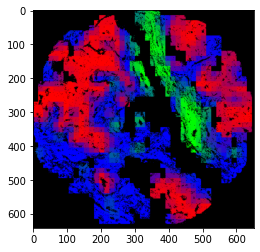

In [8]:
array_tiles=np.asarray(tiles)
locs=array_tiles[:,:2]
X=array_tiles[:,2:]
prob_map=SparTile.hmapgen(probs,locs,30,[nr,nc],tissue_mask)
plt.imshow(prob_map)

Now we classify tiles and pixels as tumor, stroma, or immune. We will need them to train our sparse NMF model.

In [9]:
###classifiy tiles
tissue_type=np.argmax(probs,axis=1)  ###tumor is class 0 stroma is 1 and immune is 2
##classify pixels, will need them later
pixel_tissue_type=np.argmax(prob_map,axis=2)

Now we want to train sparse NMF models for tumor, stroma, and immune region types. Since we are using only 1 image instead of a full dataset, we used 5 NMF componenets for each region type. Note we used sklearn to train NMF models, but any other package can be used as well. First we do tumor.

In [11]:
tum_tiles=X[tissue_type==0,:]
tum_df=pd.DataFrame(tum_tiles,columns=columns[2:])
##remove rare chans
tum_df,comchans = SparTile.feat_sel(tum_df)
##build nmf model and transform
tumor_nmf_model=NMF(n_components=5, alpha_W=0.01,alpha_H=0.01,l1_ratio=0.5).fit(np.asarray(tum_df))
Xtumnmf=tumor_nmf_model.transform(X[:,comchans])
#####bring to pixel level
tum_im=SparTile.hmapgen(Xtumnmf,locs,30,[nr,nc],tissue_mask)

Now we do stroma

In [12]:
str_tiles=X[tissue_type==1,:]
str_df=pd.DataFrame(str_tiles,columns=columns[2:])
str_df,comchans = SparTile.feat_sel(str_df)
str_nmf_model=NMF(n_components=5, alpha_W=0.01,alpha_H=0.01,l1_ratio=0.5).fit(np.asarray(str_df))
Xstrnmf=str_nmf_model.transform(X[:,comchans])
str_im=SparTile.hmapgen(Xstrnmf,locs,30,[nr,nc],tissue_mask)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


And finally immune

In [13]:
imm_tiles=X[tissue_type==2,:]
imm_df=pd.DataFrame(imm_tiles,columns=columns[2:])
imm_df,comchans = SparTile.feat_sel(imm_df)
imm_nmf_model=NMF(n_components=5, alpha_W=0.01,alpha_H=0.01,l1_ratio=0.5).fit(np.asarray(imm_df))
Ximmnmf=imm_nmf_model.transform(X[:,comchans])
imm_im=SparTile.hmapgen(Ximmnmf,locs,30,[nr,nc],tissue_mask)

We stitch these represenations and cluster each pixel based on its region type and sNMF representation.

In [14]:
nmf_im=np.concatenate((tum_im,str_im,imm_im),axis=2)
cl_map=SparTile.cluster(nmf_im,pixel_tissue_type,tissue_mask,[5,5,5])

Let's visualize SparTile's clustering, shades of red are tumor MEs, shades of green are srtoma MEs, and shades of blue are immune MEs.

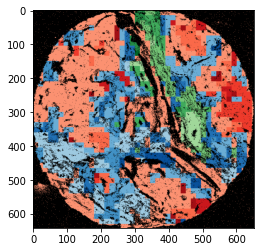

In [15]:
colsR=np.asarray(sns.color_palette("Reds", 7))
colsG=np.asarray(sns.color_palette("Greens", 7))
colsB=np.asarray(sns.color_palette("Blues", 7))
colormap=np.concatenate((colsR[2:,:],colsG[2:,:],colsB[2:,:]),axis=0)

cl_img=SparTile.clmap_viser(cl_map,colormap)
plt.imshow(cl_img)

Now we compute the area, i.e., the number of pixels, belonging to each ME. Note we provide the number of MEs that may exist, whichc is the sum of NMF dimensions for tumor, stroma, and immune region types.

In [16]:
area=SparTile.comp_area(cl_map,clust_num=15)
print(area)

[105807.  13351.  10127.   5353.   3778.   5523.  10849.   5886.   1705.
    172.  26910.  36062.  20404.  15547.   4410.]


Here are two helper functions for interpreting SparTile's MEs. The first one creates a list of top markers and marker-pairs used by the NMF models. The second, provides the average expression of each marker in Spartile's MEs or each region type.

In [17]:
weights_df, top_prots_df=SparTile.interpret_nmf(tumor_nmf_model,top_dim=10,df=tum_df)
weights_df

,Pan_CK,HLA-ABC,HLA-DR,Epcam-ECadherin,Collagen_I,aSMA,VIM,CD31,CD45,CD68,...,Epcam-ECadherin-CD3,Collagen_I-aSMA,Collagen_I-VIM,Collagen_I-CD31,Collagen_I-CD45,Collagen_I-CD68,Collagen_I-CD14,Collagen_I-CD3,aSMA-VIM,aSMA-CD31
0,1.350803,0.503979,0.015416,0.020412,0.023753,0.006049,0.198197,4.416582,0.029071,0.371542,...,0.001688,0.043067,0.085021,0.001608,0.170708,0.004138,0.015605,0.024743,0.061374,0.042612
1,1.188605,0.000000,0.000000,0.000000,0.000000,0.000000,0.285274,0.000000,0.000000,0.231868,...,0.000000,0.000000,0.159383,0.000000,0.114803,0.000000,0.000000,0.000000,0.000000,0.026209
2,0.132588,0.000000,0.000000,0.182188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.114554,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.860127,0.000000,0.082055,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223347,0.000000,...,0.000000,0.301328,0.043746,0.000000,0.000000,0.000000,0.121885,0.124186,0.499361,0.000000


In [18]:
exprs_nmf=SparTile.measure_expr(imc,cl_map,prots=prots)

exprs_tsi=SparTile.measure_expr(imc,(1+pixel_tissue_type)*tissue_mask,prots=prots)

In [19]:
exprs_nmf

,Pan_CK,HLA-ABC,HLA-DR,Epcam-ECadherin,Collagen_I,aSMA,VIM,CD31,CD45,CD68,CD14,CD3
0,0.700782,0.263866,0.050510,0.012842,0.060782,0.071278,0.046814,0.013057,0.010484,0.020576,0.139686,0.008746
1,1.066336,0.093117,0.001829,0.013899,0.003094,0.009728,0.013207,0.014921,0.000873,0.001693,0.233593,0.005583
2,0.956949,0.119507,0.003734,0.011447,0.011255,0.234838,0.071518,0.014655,0.002923,0.009871,0.197705,0.004551
3,1.055945,0.240712,0.000650,0.023426,0.002918,0.037384,0.166444,0.028645,0.001147,0.003167,0.214259,0.008438
4,0.975367,0.216979,0.082827,0.020126,0.010327,0.065678,0.085551,0.031256,0.028649,0.126386,0.240010,0.003180
5,0.000000,0.184962,0.049917,0.000000,0.331387,1.586727,0.510061,0.051965,0.010709,0.021511,0.032514,0.003104
6,0.013833,0.074216,0.046640,0.000710,0.637154,0.688975,0.111101,0.005261,0.010199,0.009022,0.037633,0.003706
7,0.046003,0.343488,0.035231,0.001525,0.260174,1.173738,0.483186,0.067636,0.002961,0.009330,0.075477,0.001826
8,0.000000,0.063460,0.250464,0.000000,0.823288,0.533906,0.087391,0.000000,0.028400,0.136493,0.072139,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.663961,0.255789,0.390191,0.000000,0.000000,0.000000,0.037372,0.000000
